#### Import Libraries

In [1]:
import os
import shutil
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, precision_score,classification_report,
    recall_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#### Load Datasets

##### Copy Dataset to Local Folder

In [2]:
path = kagglehub.dataset_download("stealthtechnologies/employee-attrition-dataset")

dataset_dir = "./datasets"

os.makedirs(dataset_dir, exist_ok=True)
shutil.copytree(path, dataset_dir, dirs_exist_ok=True)

100%|██████████| 1.72M/1.72M [00:00<00:00, 3.05MB/s]

Extracting files...


'./datasets'

##### Load Train and Test Data

In [3]:
train_df = pd.read_csv("./datasets/train.csv")
test_df = pd.read_csv("./datasets/test.csv")

In [4]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59598 entries, 0 to 59597
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Employee ID               59598 non-null  int64 
 1   Age                       59598 non-null  int64 
 2   Gender                    59598 non-null  object
 3   Years at Company          59598 non-null  int64 
 4   Job Role                  59598 non-null  object
 5   Monthly Income            59598 non-null  int64 
 6   Work-Life Balance         59598 non-null  object
 7   Job Satisfaction          59598 non-null  object
 8   Performance Rating        59598 non-null  object
 9   Number of Promotions      59598 non-null  int64 
 10  Overtime                  59598 non-null  object
 11  Distance from Home        59598 non-null  int64 
 12  Education Level           59598 non-null  object
 13  Marital Status            59598 non-null  object
 14  Number of Dependents  

In [5]:
train_df.isnull().any()

,0
Employee ID,False
Age,False
Gender,False
Years at Company,False
Job Role,False
Monthly Income,False
Work-Life Balance,False
Job Satisfaction,False
Performance Rating,False
Number of Promotions,False


##### Clean Column Names

In [6]:
train_df.columns = [''.join(word.capitalize() for word in re.sub(r'[^0-9a-zA-Z]+', ' ', col).strip().split()) for col in train_df.columns]
test_df.columns = [''.join(word.capitalize() for word in re.sub(r'[^0-9a-zA-Z]+', ' ', col).strip().split()) for col in test_df.columns]

In [7]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59598 entries, 0 to 59597
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EmployeeId               59598 non-null  int64 
 1   Age                      59598 non-null  int64 
 2   Gender                   59598 non-null  object
 3   YearsAtCompany           59598 non-null  int64 
 4   JobRole                  59598 non-null  object
 5   MonthlyIncome            59598 non-null  int64 
 6   WorkLifeBalance          59598 non-null  object
 7   JobSatisfaction          59598 non-null  object
 8   PerformanceRating        59598 non-null  object
 9   NumberOfPromotions       59598 non-null  int64 
 10  Overtime                 59598 non-null  object
 11  DistanceFromHome         59598 non-null  int64 
 12  EducationLevel           59598 non-null  object
 13  MaritalStatus            59598 non-null  object
 14  NumberOfDependents       59598 non-nul

#### Set Target Variable

In [8]:
years_train = pd.to_numeric(train_df['YearsAtCompany'], errors='coerce')
attr_train = train_df['Attrition'].astype(str).str.strip().str.lower()

y_train = np.where((years_train >= 1) & (attr_train == 'stayed'), 1, 0)
y_train = pd.Series(y_train, name="WillStayOverAnYear", index=train_df.index)

In [9]:
years_test = pd.to_numeric(test_df['YearsAtCompany'], errors='coerce')
attr_test = test_df['Attrition'].astype(str).str.strip().str.lower()

y_test = np.where((years_test >= 1) & (attr_test == 'stayed'), 1, 0)
y_test = pd.Series(y_test, name="WillStayOverAnYear", index=test_df.index)

In [10]:
print(f"Total no. of employees                    - {len(train_df)}\n")
print(f"No. of employees stayed more than an year - {y_train.sum()}")
print(f"No. of employees stayed more than an year - {(y_train == 0).sum()}")


Total no. of employees                    - 59598

No. of employees stayed more than an year - 31260
No. of employees stayed more than an year - 28338


#### Set Features

In [11]:
drop_cols = ["Attrition", "YearsAtCompany", "EmployeeId"]
train_df = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns])
test_df = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns])

In [12]:
X_train = train_df
X_test = test_df

#### Exploratory Data Analysis & Correlation

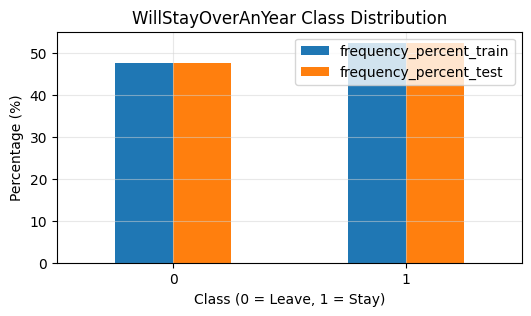

In [13]:
train_counts = y_train.value_counts(normalize=True) * 100
test_counts = y_train.value_counts(normalize=True) * 100

attack_class_dist = pd.DataFrame({'frequency_percent_train': train_counts, 'frequency_percent_test': test_counts}).sort_index()

plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar", figsize=(6,3))
plot.set_title("WillStayOverAnYear Class Distribution")
plot.set_xlabel("Class (0 = Leave, 1 = Stay)")
plot.set_ylabel("Percentage (%)")
plot.grid(color='lightgray', alpha=0.5)
plt.xticks(rotation=0)
plt.show()

##### Scaling Numerical Attributes

In [14]:
scaler = StandardScaler()

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

sc_train = scaler.fit_transform(X_train[num_cols])
sc_test = scaler.transform(X_test[num_cols])

sc_train_df = pd.DataFrame(sc_train, columns=num_cols, index=X_train.index)
sc_test_df = pd.DataFrame(sc_test, columns=num_cols, index=X_test.index)


#### Encoding Categorical Attributes

In [15]:
cat_cols = X_train.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

train_cat = encoder.fit_transform(X_train[cat_cols])
test_cat = encoder.transform(X_test[cat_cols])

encoded_cols = encoder.get_feature_names_out(cat_cols)

train_cat_df = pd.DataFrame(train_cat, columns=encoded_cols, index=X_train.index)
test_cat_df = pd.DataFrame(test_cat, columns=encoded_cols, index=X_test.index)

In [16]:
X_train_processed = pd.concat([sc_train_df, train_cat_df], axis=1)
X_test_processed = pd.concat([sc_test_df, test_cat_df], axis=1)

print("Processed train features shape:", X_train_processed.shape)
print("Processed test features shape:", X_test_processed.shape)

Processed train features shape: (59598, 55)
Processed test features shape: (14900, 55)


##### Coorelational Heatmap

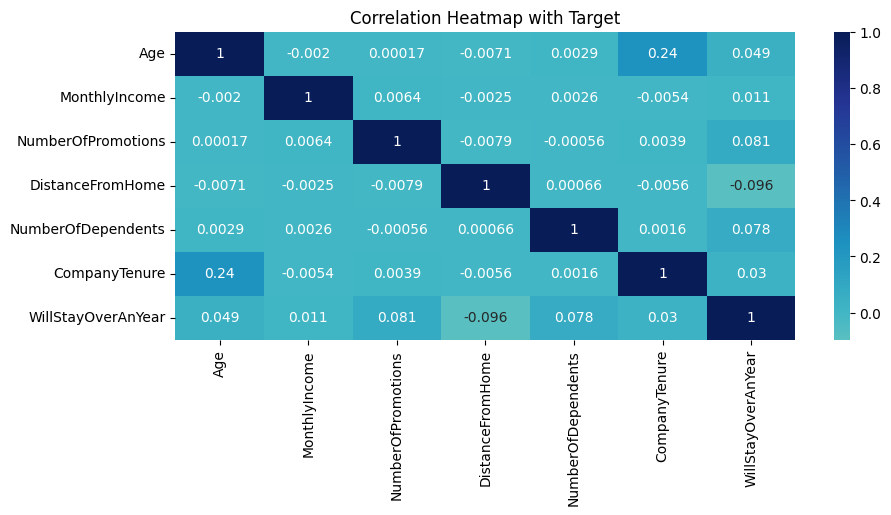

In [17]:
eda_df = train_df[num_cols].copy()
eda_df["WillStayOverAnYear"] = y_train

plt.figure(figsize=(10,4))
sns.heatmap(eda_df.corr(), cmap="YlGnBu", center=0, annot=True)
plt.title("Correlation Heatmap with Target")
plt.show()

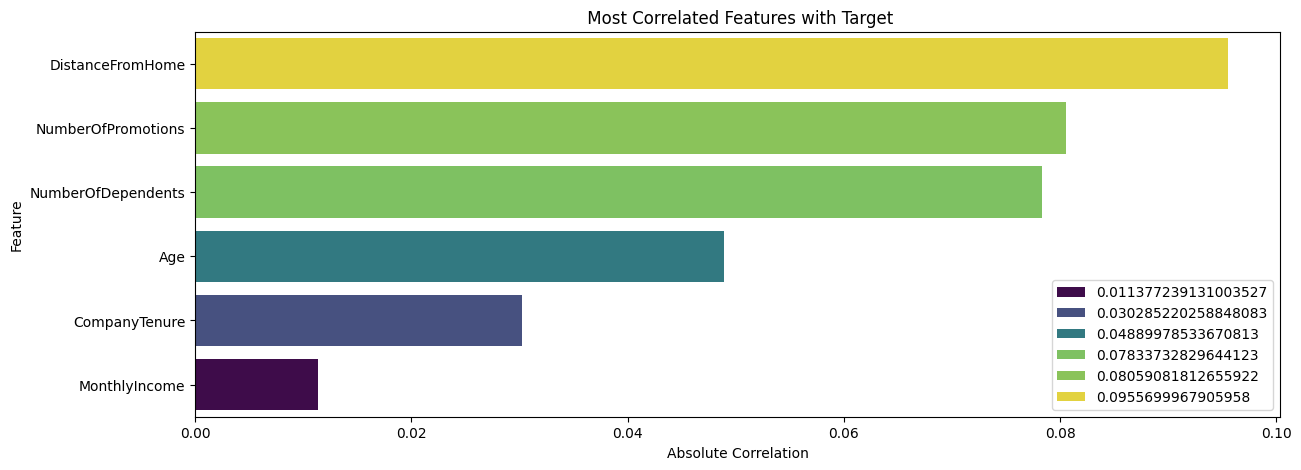

In [18]:
feature_target_corr = eda_df.corr()["WillStayOverAnYear"].drop("WillStayOverAnYear")
feature_importance = feature_target_corr.abs().sort_values(ascending=False)

plt.figure(figsize=(14,5))
sns.barplot(x=feature_importance.head(15).values, y=feature_importance.head(15).index,hue=feature_importance.head(15).values, palette="viridis")
plt.title(" Most Correlated Features with Target")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.show()

#### Training Logistic Regression Model

In [19]:
model = LogisticRegression(n_jobs=-1, random_state=0, max_iter=1000)
model.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=0)

#### Model Evaluation

In [20]:
param_grid = { 'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs'], 'max_iter': [500] }

grid = GridSearchCV(
    LogisticRegression(random_state=0),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=2,
    verbose=2
)

grid.fit(X_train_processed, y_train)

print("Best Parameters:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_processed)
print("Tuned Accuracy:", metrics.accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuned Accuracy: 0.7531543624161073


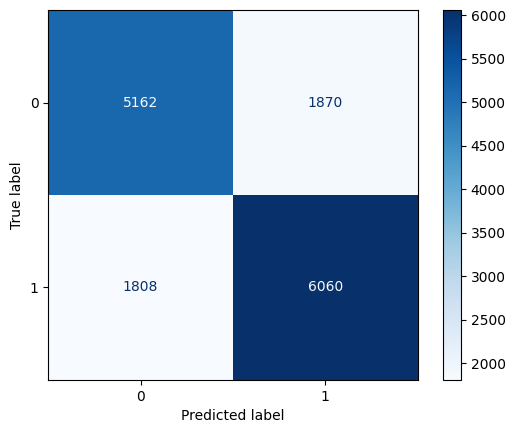

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [22]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      7032
           1       0.76      0.77      0.77      7868

    accuracy                           0.75     14900
   macro avg       0.75      0.75      0.75     14900
weighted avg       0.75      0.75      0.75     14900



AUC Score: 0.8440606034842246


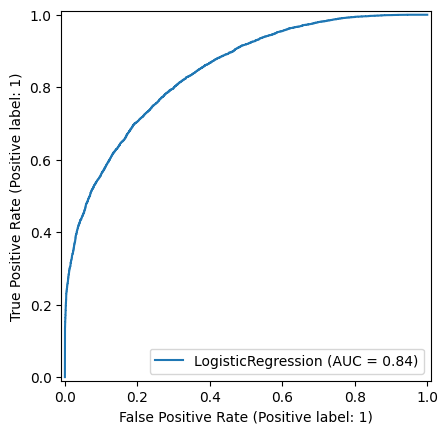

In [23]:
RocCurveDisplay.from_estimator(best_model, X_test_processed, y_test)
print("AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test_processed)[:, 1]))

In [24]:
cv_results = grid.cv_results_['mean_test_score']
print("Average CV Accuracy:", np.mean(cv_results))

Average CV Accuracy: 0.7505327359978523
